## План EDA

**Провести анализ текстов:**
   
   1. расчитать среднюю, минимальную и максимальную длины текстов (визуализация распределения);
   2. частотный анализ слов и **n-грамм**, извлечение **биграмм** и **триграмм**;
   3. статистики по символам и словам, распределение частей речи;
   4. анализ метаинформации (дата публикации, авторство и т.д.), корреляция между признаками и текстами;
   5. Изучить связь текстовых признаков с целевой переменной.

**Визуализация данных:**
   
   1. распределения классов, меток или числовых признаков;
   2. облако наиболее частотных слов и биграмм для выявления ключевых тем (Word Clouds);
   3. методы снижения размерности (например, t-SNE) для визуализации текстовых представлений.


**Первичная предобработка текста:**
   
   1. оценить и обработать пропуски, дубликаты; 
   2. очистить текст от шумовых данных: ненужных символов, HTML-тегов, специальных символов;
   3. преобразовать регистр, исключить стоп-слова;
   4. провести токенизацию (разбить на слова, предложения, символы), лемматизацию или стемминг.

**Вывод:** оформить вывод о структуре данных, их особенностях и потенциальных проблемах на основе проведенного разведочного анализа данных.

## Импорт библиотек

In [1]:
!pip install langdetect
!pip install pymorphy2
!pip install wordcloud
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 11.4 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993227 sha256=22c644c11967ae0ae08ad770fc8af17a86b80e8680434c81d156ebfc125bb573
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 55.8 MB/s eta 0:00:0000:0100:01
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb

In [2]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

import string

import nltk
import spacy

from bs4 import BeautifulSoup
import re

from nltk import tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from langdetect import detect

nltk.download('wordnet')
nltk.download('corpora')

from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from tqdm import tqdm


sns.set_theme(rc={'figure.figsize':(10, 5)})

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Error loading corpora: Package 'corpora' not found in
[nltk_data]     index
/kaggle/input/top100-d/top100.pq
/kaggle/input/books-dataset/books_text_final_new.csv


## Загрузка данных

In [3]:
RANDOM_STATE = 17

In [4]:
#data = pd.read_csv('/kaggle/input/books-dataset/books_text_final_new.csv')
#data = data.drop(['Unnamed: 0'], axis=1)

In [5]:
data = pd.read_parquet('/kaggle/input/top100-d/top100.pq')
data = data[['author', 'title', 'text_']]
data = data.rename({'text_': 'text'}, axis=1)

In [6]:
# Функция для краткого описания данных
def data_info(df):
    print(f'Количество строк - {df.shape[0]}\n', f'Количество столбцов - {df.shape[1]}', sep='')
    
    display(df.head())
    return df.info()

In [7]:
# Функция для визуализации распределений
def hist_plot(data, bins=100, box=True):
    display(pd.DataFrame(data).describe().round(3).T)
    
    data.hist(bins=bins)
    plt.show()
    
    if box:
        data.plot(kind='box', vert=False, figsize=(10, 3))

In [8]:
data_info(data)

Количество строк - 409
Количество столбцов - 3


,author,title,text
0,Geoffrey_Chaucer,The_Canterbury_Tales,THE CANTERBURY TALES And other Poems of GEOFF...
1,Umberto_Eco,From_The_Tree_To_The_Labyrinth,FROM THE TREE TO THE LABYRINTH FROM THE TREE ...
2,Victor_Hugo,Les_Misérables,LES MISÉRABLES By Victor Hugo Translated by I...
3,Jalaluddin_Muhammad_Rumi,The_Mathnawi,"The Safar-nima, Rawshan 4 ’f-ndma and Sa'adat-..."
4,Alexandre_Dumas,Celebrated_Crimes_(complete),"</p> </div> <div class=""vspace"" style=""height:..."


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409 entries, 0 to 408
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   author  409 non-null    object
 1   title   409 non-null    object
 2   text    409 non-null    object
dtypes: object(3)
memory usage: 9.7+ KB


Для EDA будет использована только выборка данных.

In [9]:
data_all = data
print(data_all.shape)

data = data_all.sample(150, random_state=RANDOM_STATE)
print(data.shape)

(409, 3)
(150, 3)


## Предобработка данных ч1.

Для проведения исследовательского анализа нужно предварительной провести частичную предобработку данных, чтобы убрать служебную информацию издательств, теги, не англоязычные тексты и т.д.

Перед тем как проводить частотный анализ слов и n-грамм, нужно очистить текст, удалить стоп-слова, удалить тексты не на английском языке.

In [10]:
data['text_language'] = data['text'].apply(detect)
data = data.query("text_language == 'en'")
data.head()

,author,title,text,text_language
252,Antoine_De_Saint_Exupery,The_Little_Prince,Antoine de Saint-Exupery The Little Prince To ...,en
221,Mark_Twain,Personal_Recollections_Of_Joan_Of_Arc_—_Volume_1,"Produced by David Reed, and David Widger PERS...",en
355,Charles_Dickens,Hunted_Down:_The_Detective_Stories_Of_Charles_...,Transcribed from the 1905 Chapman and Hall “H...,en
236,Alexandre_Dumas,Black_Tulip,THE BLACK TULIP By Alexandre Dumas (Pere) Chap...,en
343,Alexandre_Dumas,Marquise_De_Ganges,"</p> </div> <div class=""vspace"" style=""height:...",en


Удалим все HTML-теги текстов.

In [11]:
# Функция для удаления HTML-тегов
def html_tags(html):
    return int(bool(BeautifulSoup(html, "html.parser").find()))

In [12]:
data['has_html'] = data['text'].apply(html_tags)
data = data.query("has_html == 0")
data.head()

,author,title,text,text_language,has_html
252,Antoine_De_Saint_Exupery,The_Little_Prince,Antoine de Saint-Exupery The Little Prince To ...,en,0
221,Mark_Twain,Personal_Recollections_Of_Joan_Of_Arc_—_Volume_1,"Produced by David Reed, and David Widger PERS...",en,0
355,Charles_Dickens,Hunted_Down:_The_Detective_Stories_Of_Charles_...,Transcribed from the 1905 Chapman and Hall “H...,en,0
236,Alexandre_Dumas,Black_Tulip,THE BLACK TULIP By Alexandre Dumas (Pere) Chap...,en,0
122,Agatha_Christie,The_Mysterious_Affair_At_Styles,The Mysterious Affair at Styles by Agatha Chr...,en,0


Теперь удалим предисловие и послесловие от Gutenberg из каждого текста.

In [13]:
def book_txt(row):
    try:
        row = row.split('*** START OF THE PROJECT GUTENBERG EBOOK ')[1]
        row = row.split('*** END OF THE PROJECT GUTENBERG ')[0]
        return row
    except:
        try:
            row = row.split('*** START OF THIS PROJECT GUTENBERG EBOOK ')[1]
            row = row.split('*** END OF THIS PROJECT GUTENBERG ')[0]
            return row
        except:
            return row

In [14]:
data['text'] = data['text'].apply(book_txt)

Теперь переведем все в lower_case, удалим лишние символы.

In [15]:
data['text_cleaned'] = data['text'].str.lower().str.replace('[^a-z A-Z 0-9-]+', ' ', regex=True)\
                                               .str.replace('\s+-\s+', ' ', regex=True)
data['text_cleaned'].head(5)

252    antoine de saint-exupery the little prince to ...
221     produced by david reed  and david widger pers...
355     transcribed from the 1905 chapman and hall  h...
236    the black tulip by alexandre dumas  pere  chap...
122     the mysterious affair at styles by agatha chr...
Name: text_cleaned, dtype: object

## Анализ текстов

Провести анализ текстов: 
- расчет средней, минимальной и максимальной длины текстов (визуализация
распределения);
- частотный анализ слов и n-грамм, извлечение биграмм и триграмм, статистики по
символам и словам, распределение частей речи.

### Количество символов в тексте

In [16]:
lengths_of_texts = data['text'].str.len()

,count,mean,std,min,25%,50%,75%,max
text,140.0,455922.521,458402.093,11389.0,140061.5,329891.5,581661.0,3191734.0


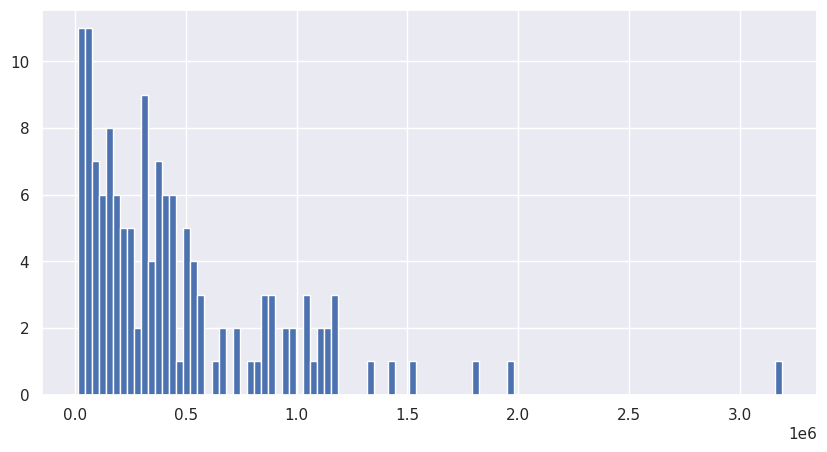

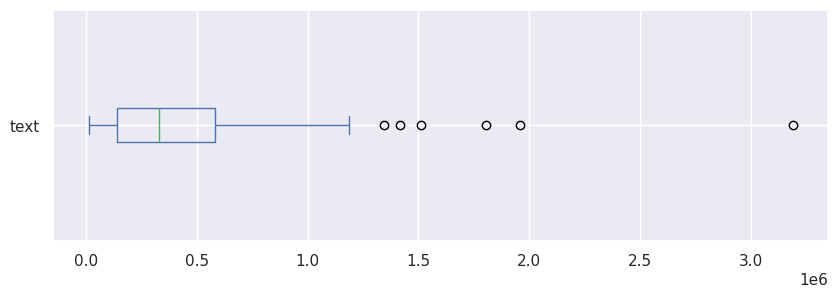

In [17]:
hist_plot(lengths_of_texts)

### Количество слов в тексте

In [18]:
# Количество слов в тексте
def word_count(review):
    review_list = review.split()
    return len(review_list)

In [19]:
words_of_texts = data['text'].apply(word_count)

,count,mean,std,min,25%,50%,75%,max
text,140.0,81956.314,82018.198,2095.0,25087.25,59650.5,104142.75,563286.0


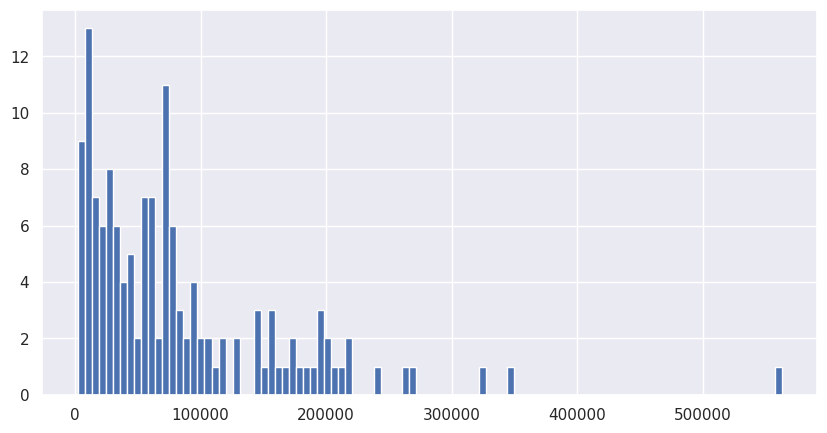

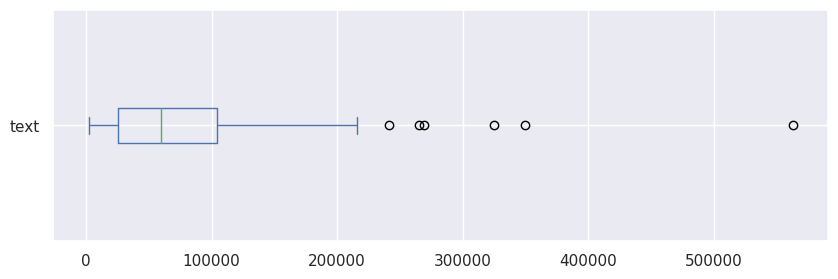

In [20]:
hist_plot(words_of_texts)

### Частотный анализ слов и n-грамм

In [21]:
# Разбиваем текст на слова
data['text_cleaned_words'] = data['text_cleaned'].apply(lambda x: word_tokenize(x))
# Очищаем от стоп слов
stop_words = stopwords.words("english") + ['--']
data['text_cleaned_words'] = data['text_cleaned_words'].apply(lambda review: [word for word in review if word not in stop_words])

# Соединяем в очищенный текст
data['text_cleaned'] = data['text_cleaned_words'].apply(lambda text: " ".join(text))

data.head()

,author,title,text,text_language,has_html,text_cleaned,text_cleaned_words
252,Antoine_De_Saint_Exupery,The_Little_Prince,Antoine de Saint-Exupery The Little Prince To ...,en,0,antoine de saint-exupery little prince leon we...,"[antoine, de, saint-exupery, little, prince, l..."
221,Mark_Twain,Personal_Recollections_Of_Joan_Of_Arc_—_Volume_1,"Produced by David Reed, and David Widger PERS...",en,0,produced david reed david widger personal reco...,"[produced, david, reed, david, widger, persona..."
355,Charles_Dickens,Hunted_Down:_The_Detective_Stories_Of_Charles_...,Transcribed from the 1905 Chapman and Hall “H...,en,0,transcribed 1905 chapman hall hard times repri...,"[transcribed, 1905, chapman, hall, hard, times..."
236,Alexandre_Dumas,Black_Tulip,THE BLACK TULIP By Alexandre Dumas (Pere) Chap...,en,0,black tulip alexandre dumas pere chapter 1 gra...,"[black, tulip, alexandre, dumas, pere, chapter..."
122,Agatha_Christie,The_Mysterious_Affair_At_Styles,The Mysterious Affair at Styles by Agatha Chr...,en,0,mysterious affair styles agatha christie conte...,"[mysterious, affair, styles, agatha, christie,..."


In [22]:
all_texts_words = []
for i in tqdm(range(data.shape[0])):
    all_texts_words += data['text_cleaned_words'].iloc[i]
len(all_texts_words)

100%|██████████| 140/140 [00:00<00:00, 1850.23it/s]


5541547

In [23]:
word_counter = Counter(all_texts_words)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


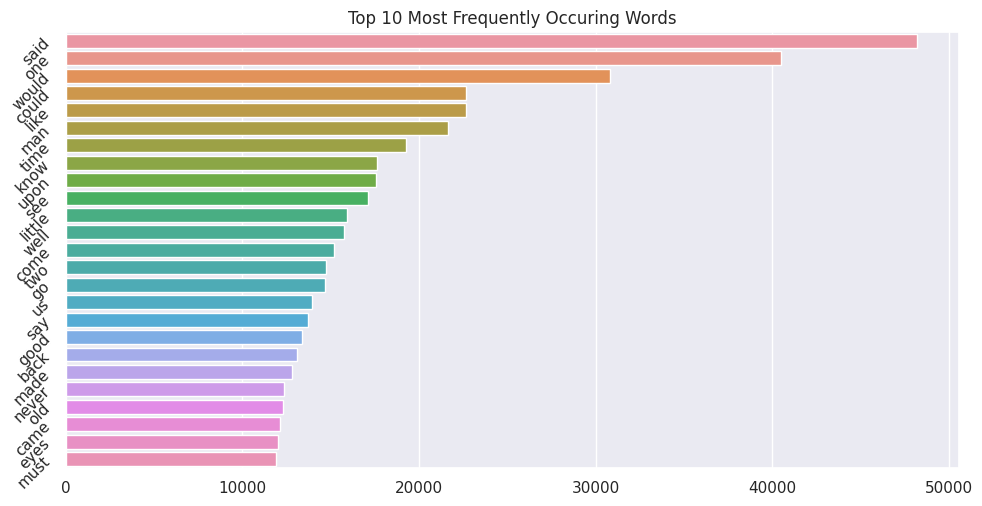

In [24]:
words = []
counter = []

for word, count in word_counter.most_common(25):
    words.append(word)
    counter.append(count)

sns.barplot(x=counter, y=words)
plt.yticks(rotation=45)
plt.tight_layout()
plt.title('Top 25 Most Frequently Occuring Words')
plt.show()

n-грамм, извлечение биграмм и триграмм, статистики по
символам и словам, распределение частей речи.

In [25]:
def ngrams(df_col, ngram_range=(2, 2)):
    count_vect = CountVectorizer(ngram_range=ngram_range)
    bigram_count = count_vect.fit_transform(df_col).toarray().sum(axis=0)
    
    ngram_freq = pd.DataFrame(sorted([(bigram_count[i], k) for k, i in count_vect.vocabulary_.items()], reverse = True))
    ngram_freq.columns = ["frequency", "ngram"]
   
    return ngram_freq

In [26]:
ngram2_freq = ngrams(data['text_cleaned'])
ngram2_freq.head()

,frequency,ngram
0,1882,let us
1,1791,old man
2,1600,young man
3,1342,could see
4,1224,one another


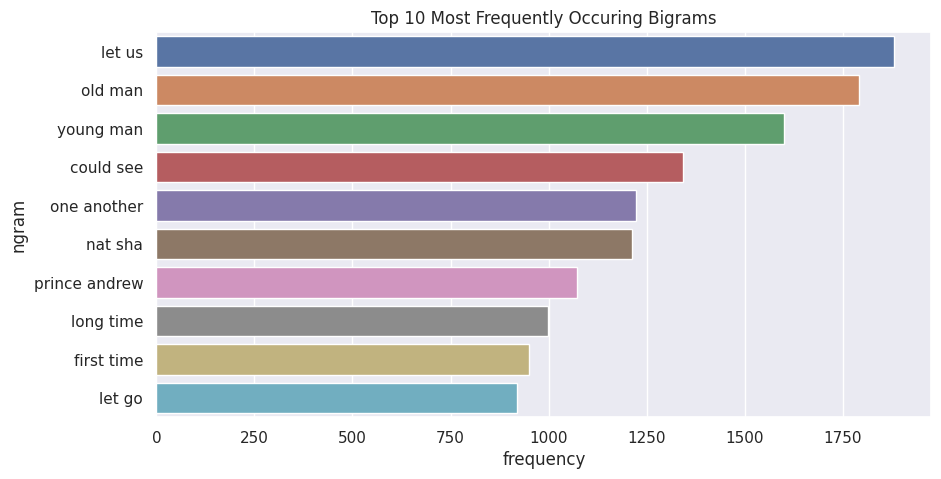

In [27]:
sns.barplot(x=ngram2_freq['frequency'][:10], y=ngram2_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Bigrams')
plt.show()

In [28]:
ngram3_freq = ngrams(data['text_cleaned'], ngram_range=(3, 3))
ngram3_freq.head()

,frequency,ngram
0,251,let us go
1,225,prince vas li
2,203,said mr boffin
3,173,ha ha ha
4,168,de la mole


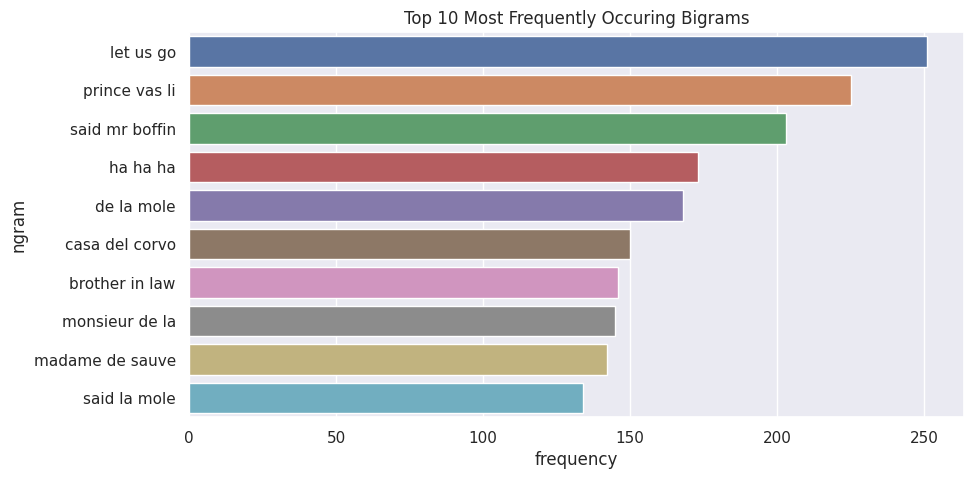

In [29]:
sns.barplot(x=ngram3_freq['frequency'][:10], y=ngram3_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Bigrams')
plt.show()

In [30]:
all_words = []

for wl in data['text_cleaned_words']:
    all_words += wl

all_words = list(set(all_words))
pos_tags = list(map(lambda x: x[1], nltk.pos_tag(all_words)))
pos_counter = Counter(pos_tags)

print(pos_tags[:10])

['JJ', 'CD', 'JJ', 'JJ', 'NN', 'VBG', 'JJ', 'NN', 'NNS', 'JJ']


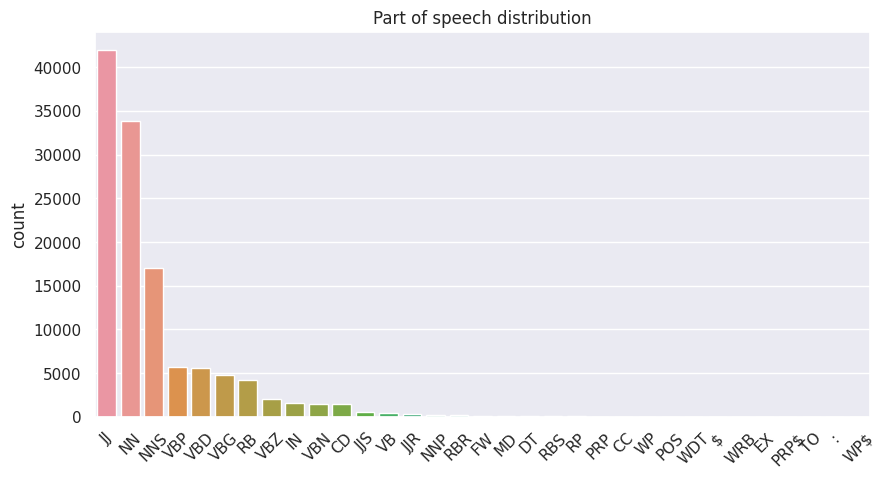

In [31]:
sns.countplot(x=pos_tags,
              order=pd.Series(pos_counter).sort_values(ascending=False).index)
plt.xticks(rotation=45)
plt.title('Part of speech distribution')
plt.show()

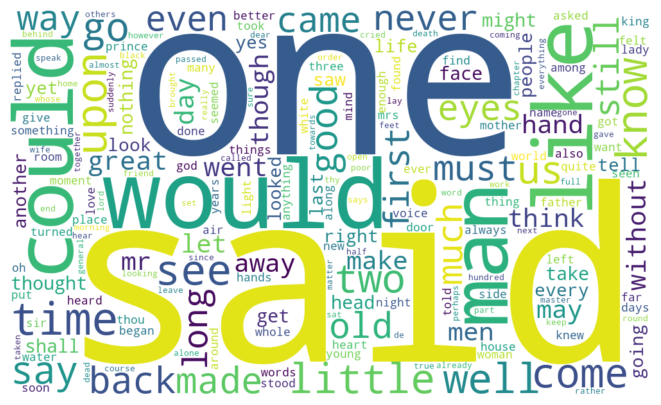

In [32]:
# Создание облака слов
wordcloud = WordCloud(width=1000, height=600, background_color='white').generate_from_frequencies(word_counter)

# Визуализация
plt.figure(figsize=(15, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Убираем оси
plt.show()

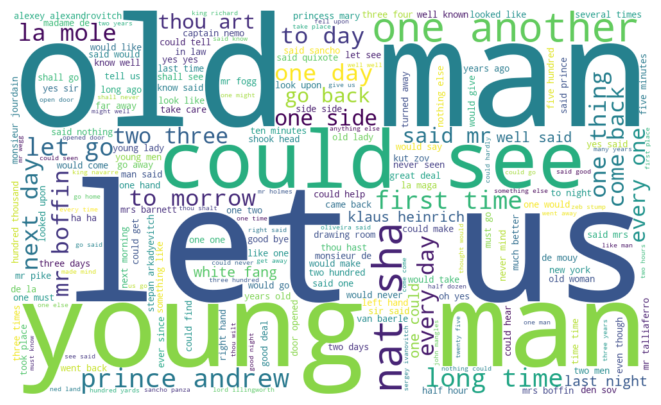

In [33]:
bigram_counter = pd.Series(ngram2_freq.frequency.values, index=ngram2_freq.ngram).to_dict()

# Создание облака слов
wordcloud = WordCloud(width=1000, height=600, background_color='white').generate_from_frequencies(bigram_counter)

# Визуализация
plt.figure(figsize=(15, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Убираем оси
plt.show()

## Предобработка данных ч2.

Теперь нужно провести лемматизацию/стемминг, а также представить тексты в векторном виде.

In [34]:
# Функция для лемматизации токенов и объединения их в один текст
def lemmatization_preprocess(tokens: list):
    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word) for word in tokens])

In [35]:
data['text_cleaned_lemmatization'] = data['text_cleaned_words'].apply(lemmatization_preprocess)
data.head()

,author,title,text,text_language,has_html,text_cleaned,text_cleaned_words,text_cleaned_lemmatization
252,Antoine_De_Saint_Exupery,The_Little_Prince,Antoine de Saint-Exupery The Little Prince To ...,en,0,antoine de saint-exupery little prince leon we...,"[antoine, de, saint-exupery, little, prince, l...",antoine de saint-exupery little prince leon we...
221,Mark_Twain,Personal_Recollections_Of_Joan_Of_Arc_—_Volume_1,"Produced by David Reed, and David Widger PERS...",en,0,produced david reed david widger personal reco...,"[produced, david, reed, david, widger, persona...",produced david reed david widger personal reco...
355,Charles_Dickens,Hunted_Down:_The_Detective_Stories_Of_Charles_...,Transcribed from the 1905 Chapman and Hall “H...,en,0,transcribed 1905 chapman hall hard times repri...,"[transcribed, 1905, chapman, hall, hard, times...",transcribed 1905 chapman hall hard time reprin...
236,Alexandre_Dumas,Black_Tulip,THE BLACK TULIP By Alexandre Dumas (Pere) Chap...,en,0,black tulip alexandre dumas pere chapter 1 gra...,"[black, tulip, alexandre, dumas, pere, chapter...",black tulip alexandre duma pere chapter 1 grat...
122,Agatha_Christie,The_Mysterious_Affair_At_Styles,The Mysterious Affair at Styles by Agatha Chr...,en,0,mysterious affair styles agatha christie conte...,"[mysterious, affair, styles, agatha, christie,...",mysterious affair style agatha christie conten...


In [36]:
# Проведем векторизацию очищенного текста
tf_idf_vectorizer = TfidfVectorizer()
data_vec = tf_idf_vectorizer.fit_transform(data['text_cleaned_lemmatization']).toarray()
data_vec = pd.DataFrame(data_vec, index=data.index, columns=tf_idf_vectorizer.get_feature_names_out())
data_vec.head()

,00,000,0000258,0000436,000157,000ft,00436,01,011,015,...,zweck,zwei,zweig,zwinger,zy,zyerral,zylo,zylobalsamum,zzip,zzzzzz
252,0.0,0.030115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
221,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
355,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
236,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
122,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Визуализация текстовых представлений

In [37]:
# В качестве меток будем использовать автора
labels = data['author']

# t-SNE
tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=3, n_iter=500) 
tsne_results = tsne.fit_transform(data_vec)

# PCA
pca = PCA(n_components=2)
pca_results = pca.fit_transform(data_vec)

# Truncated SVD (для больших и разреженных матриц)
svd = TruncatedSVD(n_components=2)
svd_results = svd.fit_transform(data_vec)

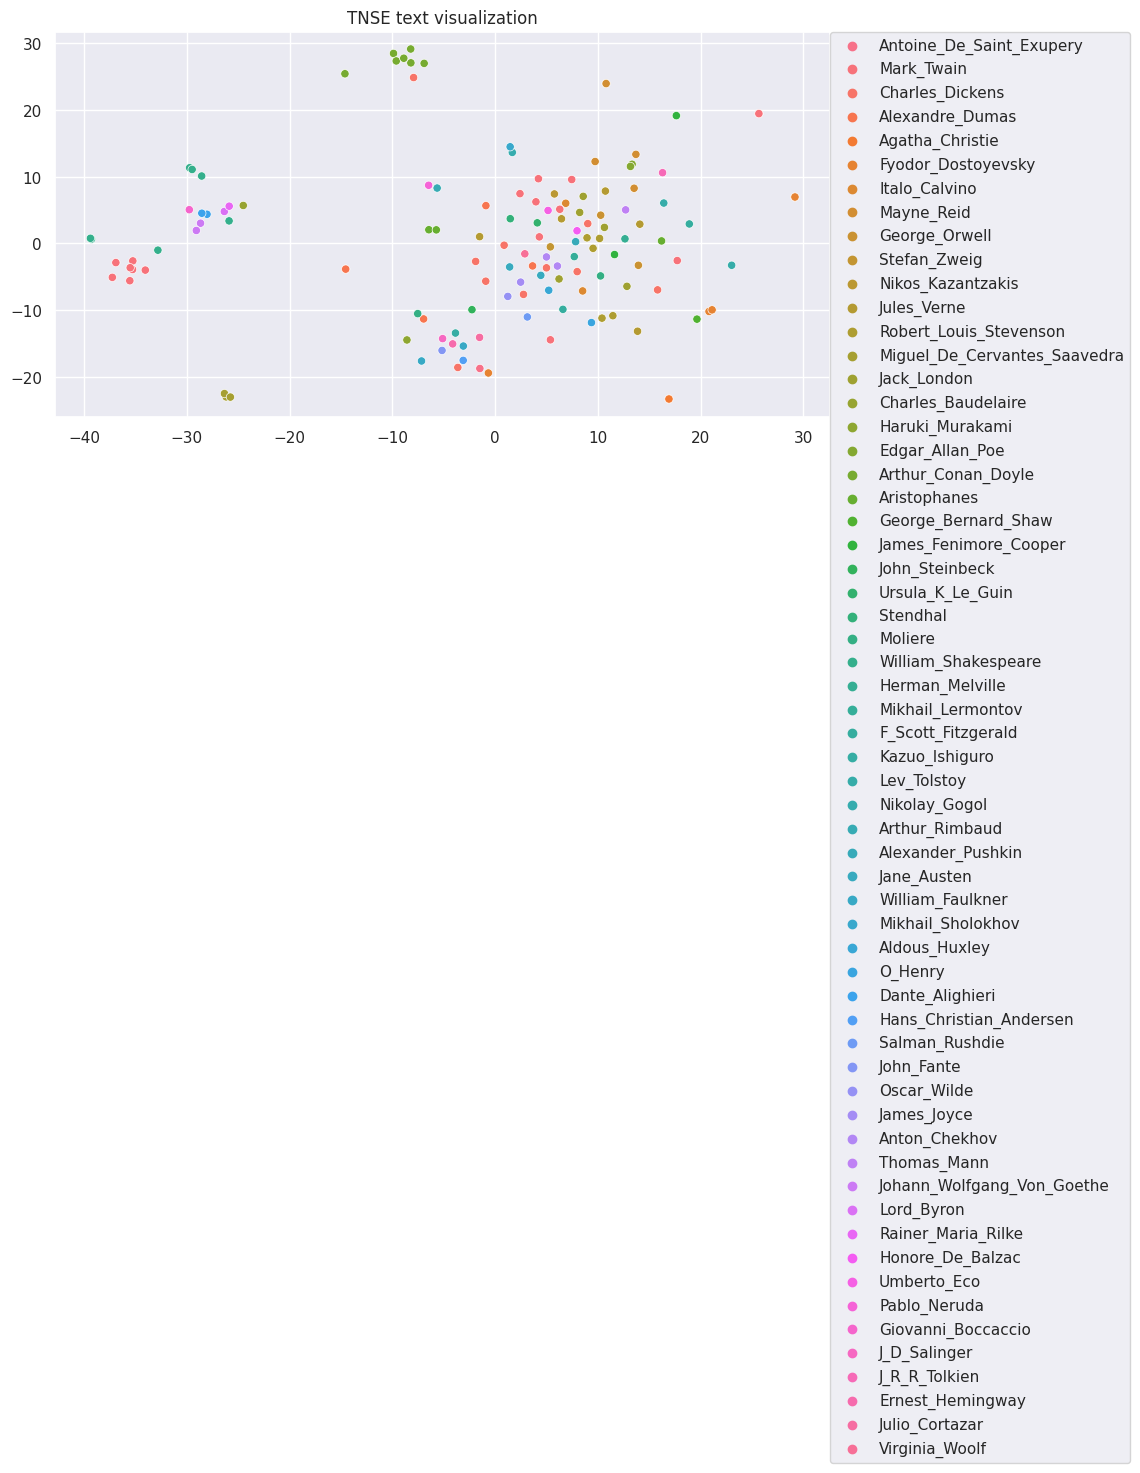

In [38]:
sns.scatterplot(x=tsne_results[:, 1], y=tsne_results[:, 0], hue=data['author']);
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.);
plt.title('TNSE text visualization');

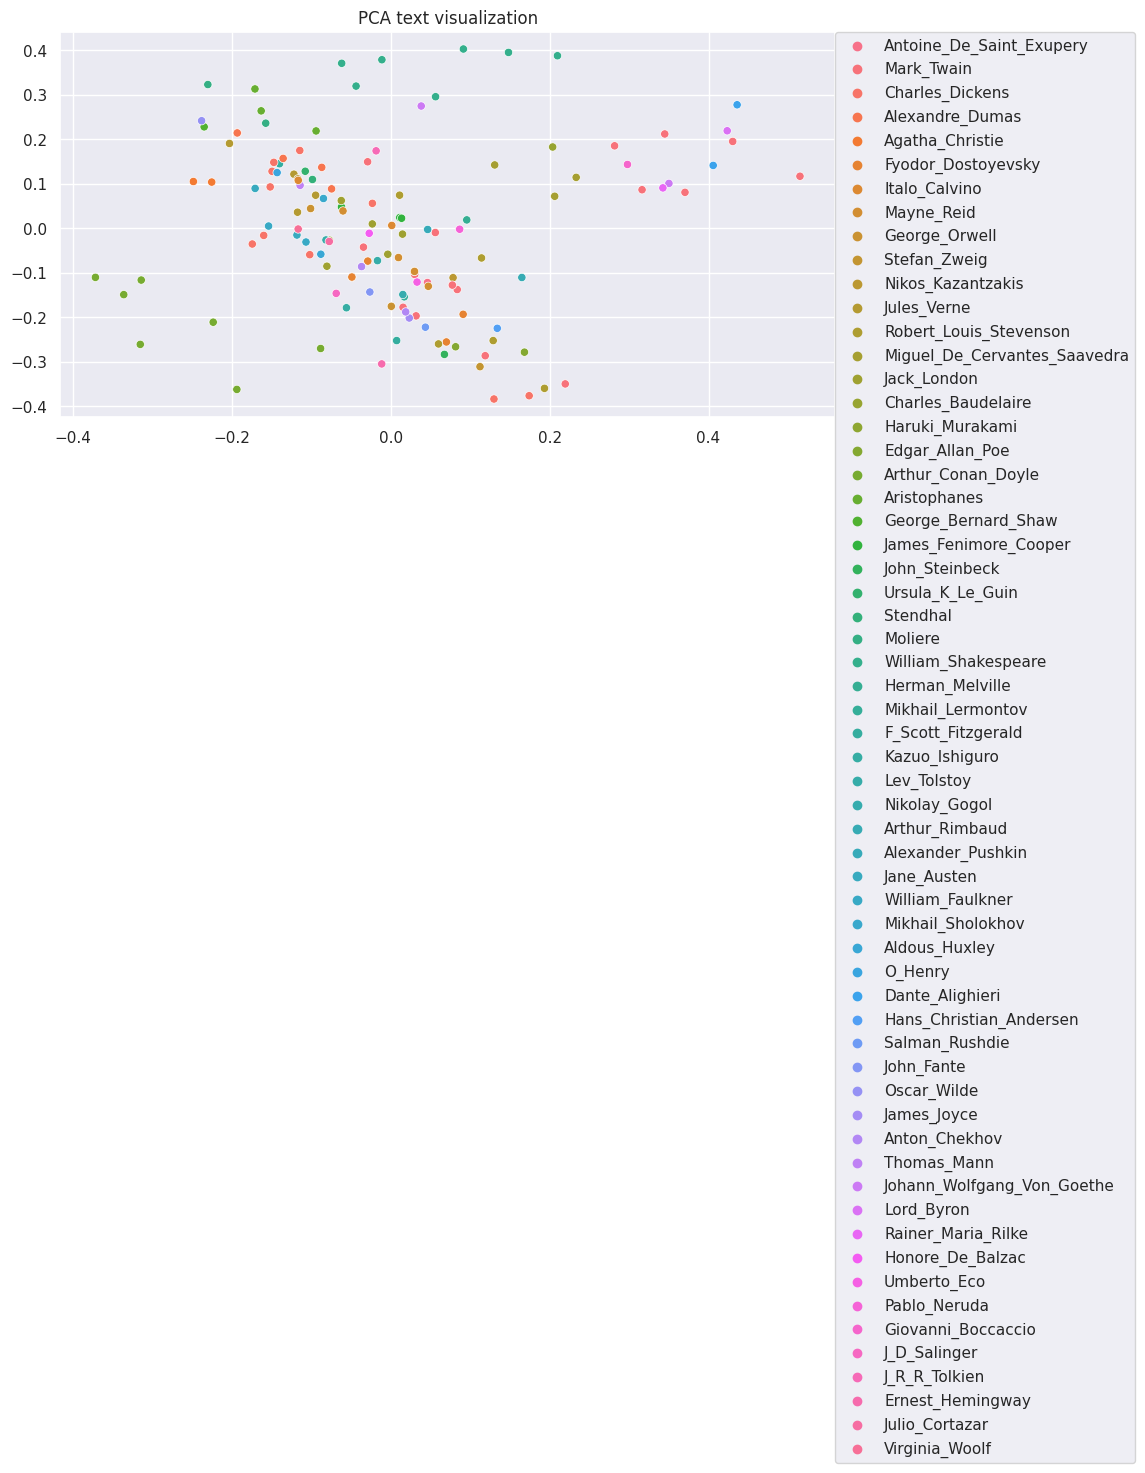

In [39]:
sns.scatterplot(x=pca_results[:, 1], y=pca_results[:, 0], hue=data['author']);
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.);
plt.title('PCA text visualization');

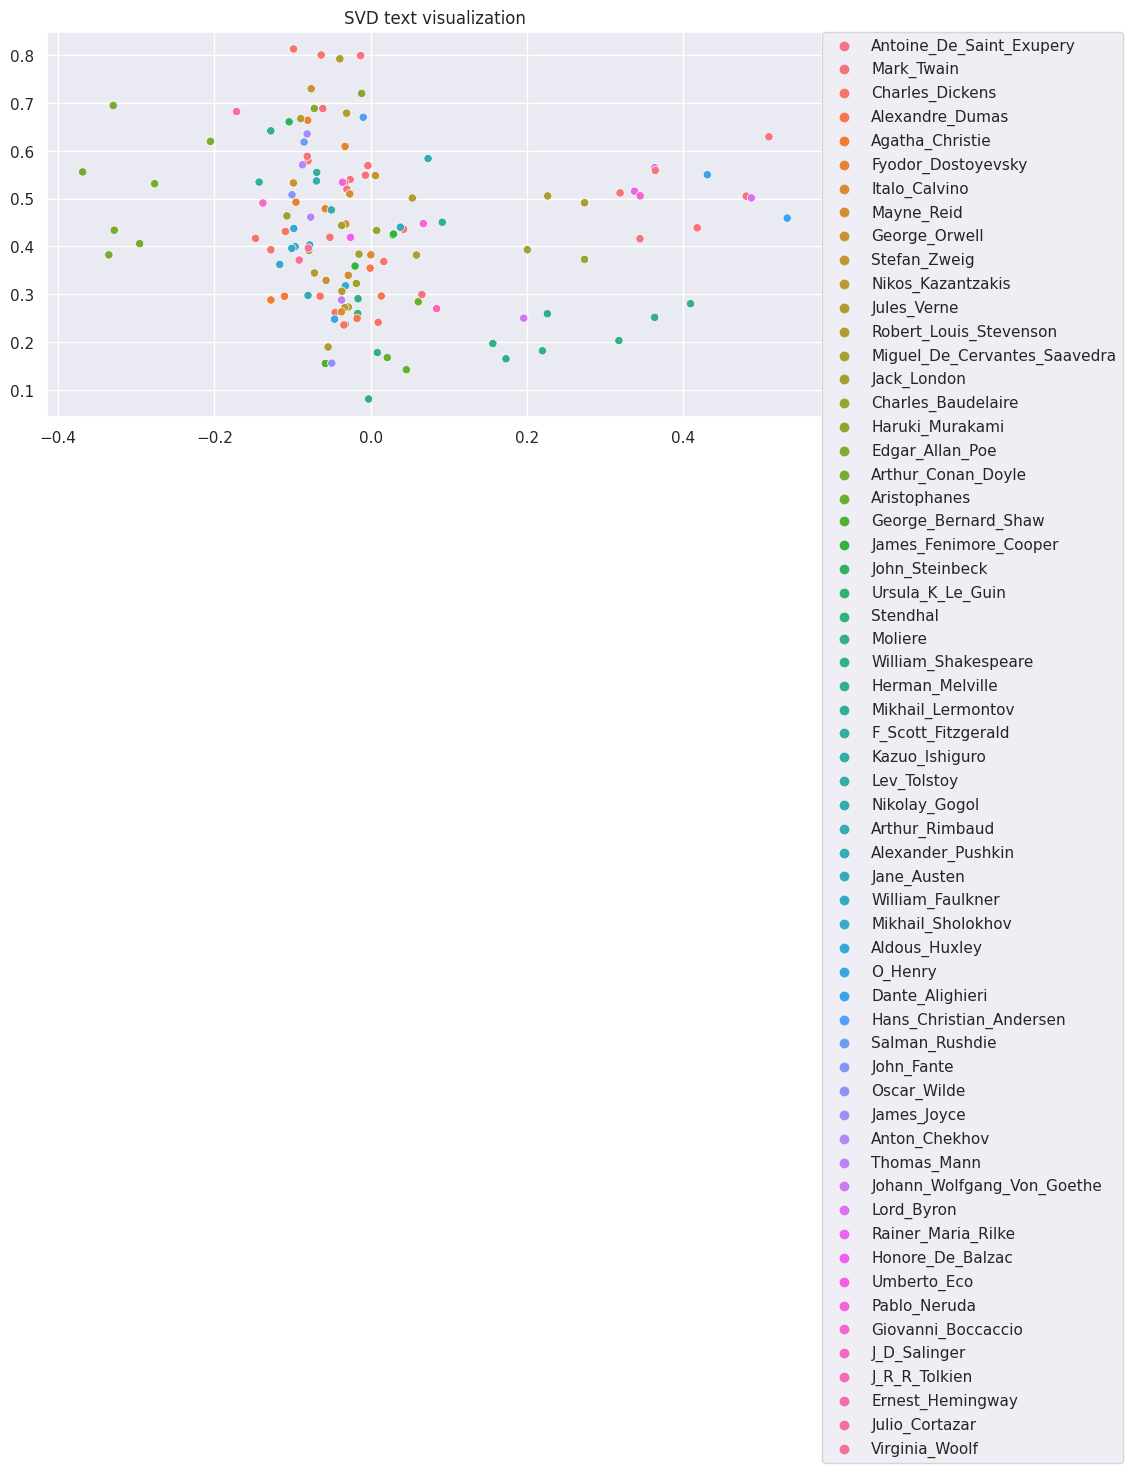

In [40]:
sns.scatterplot(x=svd_results[:, 1], y=svd_results[:, 0], hue=data['author']);
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.);
plt.title('SVD text visualization');